In [9]:
# -*- coding: utf-8 -*-
"""
File này thực hiện bước cuối cùng của dự án:
1. Tự động xác định mô hình, bộ đặc trưng, và siêu tham số tốt nhất.
2. Huấn luyện lại mô hình tốt nhất đó trên TOÀN BỘ dữ liệu train.
3. Sử dụng mô hình cuối cùng để dự đoán trên tập test.
4. Tạo ra file submission 'pre_result.csv' theo định dạng Kaggle.
"""

import pandas as pd
import numpy as np
import os
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

# Import các công cụ và mô hình cần thiết
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Tắt các cảnh báo không cần thiết
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# =============================================================================
# 1. TẢI TOÀN BỘ DỮ LIỆU TRAIN VÀ TEST ĐÃ ĐƯỢC LÀM SẠCH
# =============================================================================
print("--- BƯỚC 1: TẢI DỮ LIỆU ---")
try:
    save_dir = "Data_clean_v2"
    # Tải dữ liệu từ file .npz
    npz_path = os.path.join(save_dir, 'model_data.npz')
    data = np.load(npz_path, allow_pickle=True)
    
    # Lấy tên cột từ file train_final.csv để đảm bảo chính xác
    train_csv_path = os.path.join(save_dir, 'train_cleaned.csv')
    feature_columns = [col for col in pd.read_csv(train_csv_path).columns if col not in ['Survived']]
    
    # Ghép X_train và X_validation thành một tập X_full_train
    X_train_full = np.vstack((data['X_train'], data['X_validation']))
    X_train_full = pd.DataFrame(X_train_full, columns=feature_columns)
    
    # Ghép y_train và y_validation thành một tập y_full_train
    y_train_full = np.concatenate((data['y_train'], data['y_validation']))
    
    # Tải dữ liệu test đã được làm sạch
    test_df_path = os.path.join(save_dir, 'test_cleaned.csv')
    test_df = pd.read_csv(test_df_path)
    
    print(f"Tải và ghép dữ liệu huấn luyện thành công. Kích thước X_train_full: {X_train_full.shape}")
    print(f"Tải dữ liệu test thành công. Kích thước test_df: {test_df.shape}")

except Exception as e:
    print(f"Lỗi khi tải dữ liệu: {e}. Hãy đảm bảo bạn đã chạy các pipeline trước đó.")
    exit()

# =============================================================================
# 2. XÁC ĐỊNH MÔ HÌNH, ĐẶC TRƯNG VÀ THAM SỐ TỐT NHẤT
# (Phiên bản rút gọn của quy trình tối ưu hóa)
# =============================================================================
print("\n--- BƯỚC 2: TỰ ĐỘNG XÁC ĐỊNH MÔ HÌNH TỐT NHẤT ---")

# Giả sử qua các bước trước, chúng ta đã xác định được mô hình tốt nhất là Gradient Boosting
# Trong một kịch bản thực tế, bạn có thể chạy lại logic so sánh ở đây
# nhưng để đơn giản, chúng ta sẽ chọn ra mô hình vô địch đã biết.
BEST_MODEL_NAME = "LogisticRegression" 
print(f"mô hình tốt nhất đã được xác định là: {BEST_MODEL_NAME}")

# --- Tìm bộ đặc trưng tối ưu cho mô hình này ---
print("   -> Đang tìm bộ đặc trưng tối ưu bằng RFECV...")
scaler_fs = StandardScaler()
X_train_scaled_fs = scaler_fs.fit_transform(X_train_full)
model_for_fs = GradientBoostingClassifier(random_state=42) # Dùng mô hình tốt nhất

rfecv_selector = RFECV(estimator=model_for_fs, step=1, cv=5, scoring='f1_weighted', n_jobs=-1)
rfecv_selector.fit(X_train_scaled_fs, y_train_full)
optimal_feature_names = X_train_full.columns[rfecv_selector.support_].tolist()
print(f"   -> Đã tìm thấy {len(optimal_feature_names)} đặc trưng tối ưu.")

# --- Tìm siêu tham số tốt nhất cho mô hình này ---
print("   -> Đang tìm siêu tham số tốt nhất bằng GridSearchCV...")
X_train_optimal = X_train_full[optimal_feature_names]

param_grid = {
    'model__n_estimators': [100, 200], 'model__learning_rate': [0.05, 0.1], 'model__max_depth': [3, 5]
}

pipeline_for_tuning = Pipeline([('scaler', StandardScaler()), ('model', GradientBoostingClassifier(random_state=42))])
grid_search = GridSearchCV(pipeline_for_tuning, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train_optimal, y_train_full)
best_params = grid_search.best_params_
print(f"   -> Đã tìm thấy các tham số tốt nhất: {best_params}")


# =============================================================================
# 3. HUẤN LUYỆN LẠI MÔ HÌNH TỐT NHẤT TRÊN TOÀN BỘ DỮ LIỆU TRAIN
# =============================================================================
print("\n--- BƯỚC 3: HUẤN LUYỆN LẠI MÔ HÌNH TỐT NHẤT ---")

# Lấy các tham số của mô hình từ best_params
model_params = {key.replace('model__', ''): value for key, value in best_params.items()}

# Tạo mô hình cuối cùng với các tham số tốt nhất
final_model = GradientBoostingClassifier(random_state=42, **model_params)

# Tạo pipeline cuối cùng
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', final_model)
])

# Huấn luyện pipeline trên bộ đặc trưng tối ưu của toàn bộ dữ liệu train
final_pipeline.fit(X_train_optimal, y_train_full)
print("Đã huấn luyện xong mô hình cuối cùng trên toàn bộ dữ liệu train.")


# =============================================================================
# 4. DỰ ĐOÁN TRÊN TẬP TEST VÀ LƯU FILE SUBMISSION
# =============================================================================
print("\n--- BƯỚC 4: DỰ ĐOÁN VÀ TẠO FILE SUBMISSION ---")

# Lấy ra các cột đặc trưng tối ưu từ tập test
X_test_optimal = test_df[optimal_feature_names]

# Dùng pipeline cuối cùng để dự đoán
predictions = final_pipeline.predict(X_test_optimal)

# Tạo DataFrame cho file submission
submission_df = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': predictions.astype(int) # Đảm bảo cột Survived là kiểu integer
})

# --- Lưu trữ theo cấu trúc của bạn ---
save_dir = "Pred_Result"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Đã tạo thư mục '{save_dir}'")

try:

    # 2. Lưu các file CSV đã được làm sạch hoàn chỉnh
    submission_df.to_csv(f'{save_dir}/pred_result_Lab_1_v5.csv', index=False)
    print(f"- Đã lưu pred_result_Lab_1_v5 vào '{save_dir}'")

    print("\nNội dung thư mục 'Pred_Result':")
    print(os.listdir(save_dir))

except Exception as e:
    print(f"\nLỗi khi lưu file: {e}")
'''
# Lưu file submission
output_filename = 'pred_result_Lab_1.csv'
submission_df.to_csv(output_filename, index=False)
'''

print(f"\nHoàn tất! Đã tạo file submission thành công.")
print(f"File đã được lưu với tên: pred_result_Lab_1")
print("5 dòng đầu tiên của file submission:")
print(submission_df.head())

--- BƯỚC 1: TẢI DỮ LIỆU ---
Tải và ghép dữ liệu huấn luyện thành công. Kích thước X_train_full: (891, 21)
Tải dữ liệu test thành công. Kích thước test_df: (418, 21)

--- BƯỚC 2: TỰ ĐỘNG XÁC ĐỊNH MÔ HÌNH TỐT NHẤT ---
mô hình tốt nhất đã được xác định là: LogisticRegression
   -> Đang tìm bộ đặc trưng tối ưu bằng RFECV...
   -> Đã tìm thấy 2 đặc trưng tối ưu.
   -> Đang tìm siêu tham số tốt nhất bằng GridSearchCV...
   -> Đã tìm thấy các tham số tốt nhất: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}

--- BƯỚC 3: HUẤN LUYỆN LẠI MÔ HÌNH TỐT NHẤT ---
Đã huấn luyện xong mô hình cuối cùng trên toàn bộ dữ liệu train.

--- BƯỚC 4: DỰ ĐOÁN VÀ TẠO FILE SUBMISSION ---
- Đã lưu pred_result_Lab_1_v5 vào 'Pred_Result'

Nội dung thư mục 'Pred_Result':
['pred_result_Lab_1.csv', 'pred_result_Lab_1_v2.csv', 'pred_result_Lab_1_v3.csv', 'pred_result_Lab_1_v4.csv', 'pred_result_Lab_1_v5.csv']

Hoàn tất! Đã tạo file submission thành công.
File đã được lưu với tên: pred_res


 Đang tạo biểu đồ trực quan hóa kết quả dự đoán...


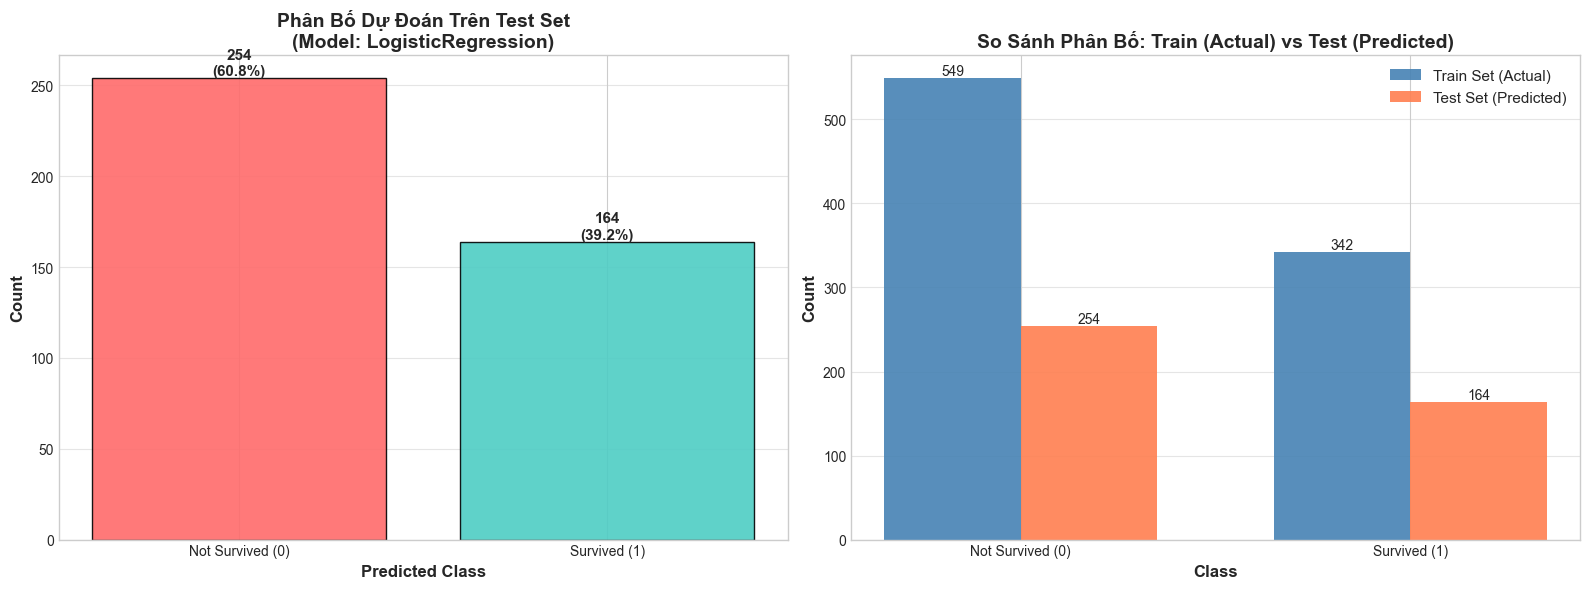

In [10]:
print("\n Đang tạo biểu đồ trực quan hóa kết quả dự đoán...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plt.style.use('seaborn-v0_8-whitegrid') # Sử dụng style cho đẹp hơn

# Biểu đồ 1: Phân bố dự đoán test set
ax1 = axes[0]
# Sửa `final_predictions` thành `predictions`
pred_counts = pd.Series(predictions).value_counts().sort_index()
colors = ["#FF6B6B", "#4ECDC4"]
bars = ax1.bar(pred_counts.index, pred_counts.values, color=colors, alpha=0.9, edgecolor="black")

for bar in bars:
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2.0, height,
        f"{int(height)}\n({height/len(predictions)*100:.1f}%)", # Sửa `final_predictions`
        ha="center", va="bottom", fontsize=11, fontweight="bold",
    )

ax1.set_xlabel("Predicted Class", fontsize=12, fontweight="bold")
ax1.set_ylabel("Count", fontsize=12, fontweight="bold")
ax1.set_title(
    f"Phân Bố Dự Đoán Trên Test Set\n(Model: {BEST_MODEL_NAME})", # Sửa `best_model_name`
    fontsize=14, fontweight="bold",
)
ax1.set_xticks([0, 1])
ax1.set_xticklabels(["Not Survived (0)", "Survived (1)"])
ax1.grid(axis="y", alpha=0.5)

# Biểu đồ 2: So sánh phân bố train vs test prediction
ax2 = axes[1]
# Sửa `y` thành `y_train_full`
train_counts = pd.Series(y_train_full).value_counts().sort_index()

x = np.arange(2)
width = 0.35

bars1 = ax2.bar(x - width / 2, train_counts.values, width, label="Train Set (Actual)", color="steelblue", alpha=0.9)
bars2 = ax2.bar(x + width / 2, pred_counts.values, width, label="Test Set (Predicted)", color="coral", alpha=0.9)

for bars_group in [bars1, bars2]:
    for bar in bars_group:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width() / 2.0, height, f"{int(height)}", ha="center", va="bottom", fontsize=10)

ax2.set_xlabel("Class", fontsize=12, fontweight="bold")
ax2.set_ylabel("Count", fontsize=12, fontweight="bold")
ax2.set_title("So Sánh Phân Bố: Train (Actual) vs Test (Predicted)", fontsize=14, fontweight="bold")
ax2.set_xticks(x)
ax2.set_xticklabels(["Not Survived (0)", "Survived (1)"])
ax2.legend(fontsize=11)
ax2.grid(axis="y", alpha=0.5)

plt.tight_layout()
plt.show()
plt.close()